In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [9]:
train_path = '/content/drive/MyDrive/train.pkl'
test_path = '/content/drive/MyDrive/test.pkl'

df = pd.read_pickle(train_path)
df_test = pd.read_pickle(test_path)

In [10]:
# Select a city
city = 'Patna'
df_city = df.xs(city, level='city').drop(['Longitude', 'Latitude'], axis=1)

In [11]:
# Drop features with too many NaN

features_to_drop = []
nrows = len(df_city)

for feature in df_city.drop(['PM2.5_target', 'PM2.5'], axis=1).columns:

    perc_nan = df_city[feature].isnull().sum()/nrows

    if perc_nan>0.8:
        print("Dropping ", feature, " since more than 80% are NaN.")
        features_to_drop.append(feature)

df_city = df_city.drop(features_to_drop, axis=1)

Dropping  CO2  since more than 80% are NaN.
Dropping  Temp  since more than 80% are NaN.
Dropping  CH4  since more than 80% are NaN.
Dropping  HCHO  since more than 80% are NaN.
Dropping  Hg  since more than 80% are NaN.
Dropping  MH  since more than 80% are NaN.
Dropping  NMHC  since more than 80% are NaN.
Dropping  O Xylene  since more than 80% are NaN.
Dropping  Power  since more than 80% are NaN.
Dropping  SPM  since more than 80% are NaN.
Dropping  THC  since more than 80% are NaN.


In [12]:
# Select most correlated features

pearson_corr = df_city.corr(method='pearson')
spearman_corr = df_city.corr(method='spearman')
kendall_corr = df_city.corr(method='kendall')

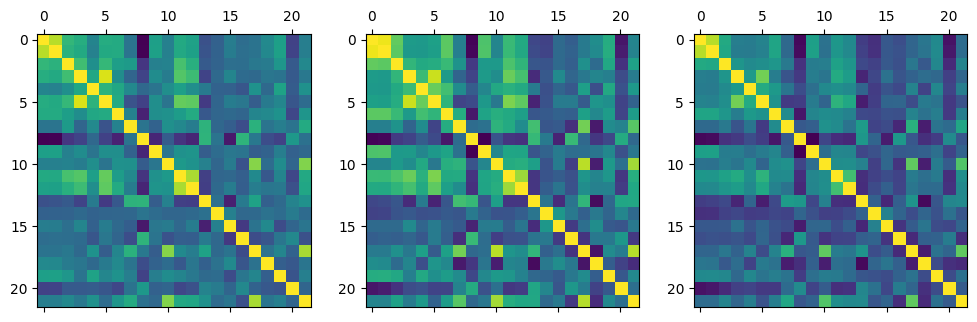

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].matshow(pearson_corr)
ax[1].matshow(spearman_corr)
ax[2].matshow(kendall_corr)
plt.show()

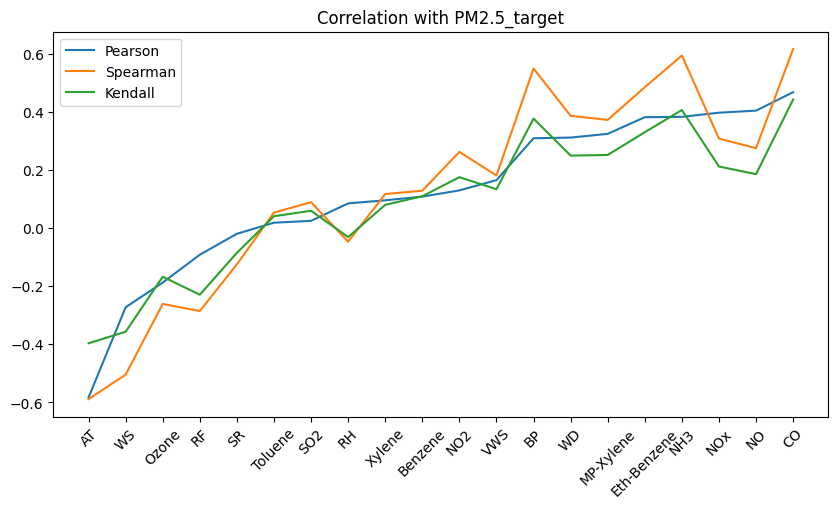

In [14]:
pearson_with_target = {feature:pearson_corr[feature]['PM2.5_target'] for feature in df_city.drop(['PM2.5_target', 'PM2.5'], axis=1)}
x = dict(sorted(pearson_with_target.items(), key=lambda item: item[1]))

spearman_with_target = [spearman_corr[feature]['PM2.5_target'] for feature in x.keys()]
kendall_with_target = [kendall_corr[feature]['PM2.5_target'] for feature in x.keys()]

plt.figure(figsize=(10,5))
plt.plot(x.keys(), x.values(), label='Pearson')
plt.plot(x.keys(), spearman_with_target, label = 'Spearman')
plt.plot(x.keys(), kendall_with_target, label='Kendall')
plt.xticks(rotation=45)

plt.title("Correlation with PM2.5_target")
plt.legend()
plt.show()


In [15]:
features_to_drop = []

for feature in df_city.drop(['PM2.5_target', 'PM2.5'], axis=1).columns:

    if np.abs(pearson_corr[feature]['PM2.5_target'])<0.25:

        if np.abs(spearman_corr[feature]['PM2.5_target'])<0.25:

            if np.abs(kendall_corr[feature]['PM2.5_target'])<0.25:

                features_to_drop.append(feature)
                print("Dropping ", feature)

df_city = df_city.drop(features_to_drop, axis=1)

Dropping  SO2
Dropping  Benzene
Dropping  RH
Dropping  SR
Dropping  Toluene
Dropping  VWS
Dropping  Xylene


In [16]:
for feature in df_city.drop(['PM2.5_target', 'PM2.5'], axis=1).columns:

    for feature2 in df_city.drop(['PM2.5_target', 'PM2.5'], axis=1).columns:

        if np.abs(pearson_corr[feature][feature2])>0.7 and np.abs(pearson_corr[feature][feature2])<1.:
            print(feature, feature2, np.abs(pearson_corr[feature][feature2]))


NO NOx 0.9128973268197043
NOx NO 0.9128973268197043
Eth-Benzene MP-Xylene 0.7971369588587222
MP-Xylene Eth-Benzene 0.7971369588587222


In [17]:
df_city = df_city.drop(['NOx', 'MP-Xylene'], axis=1)

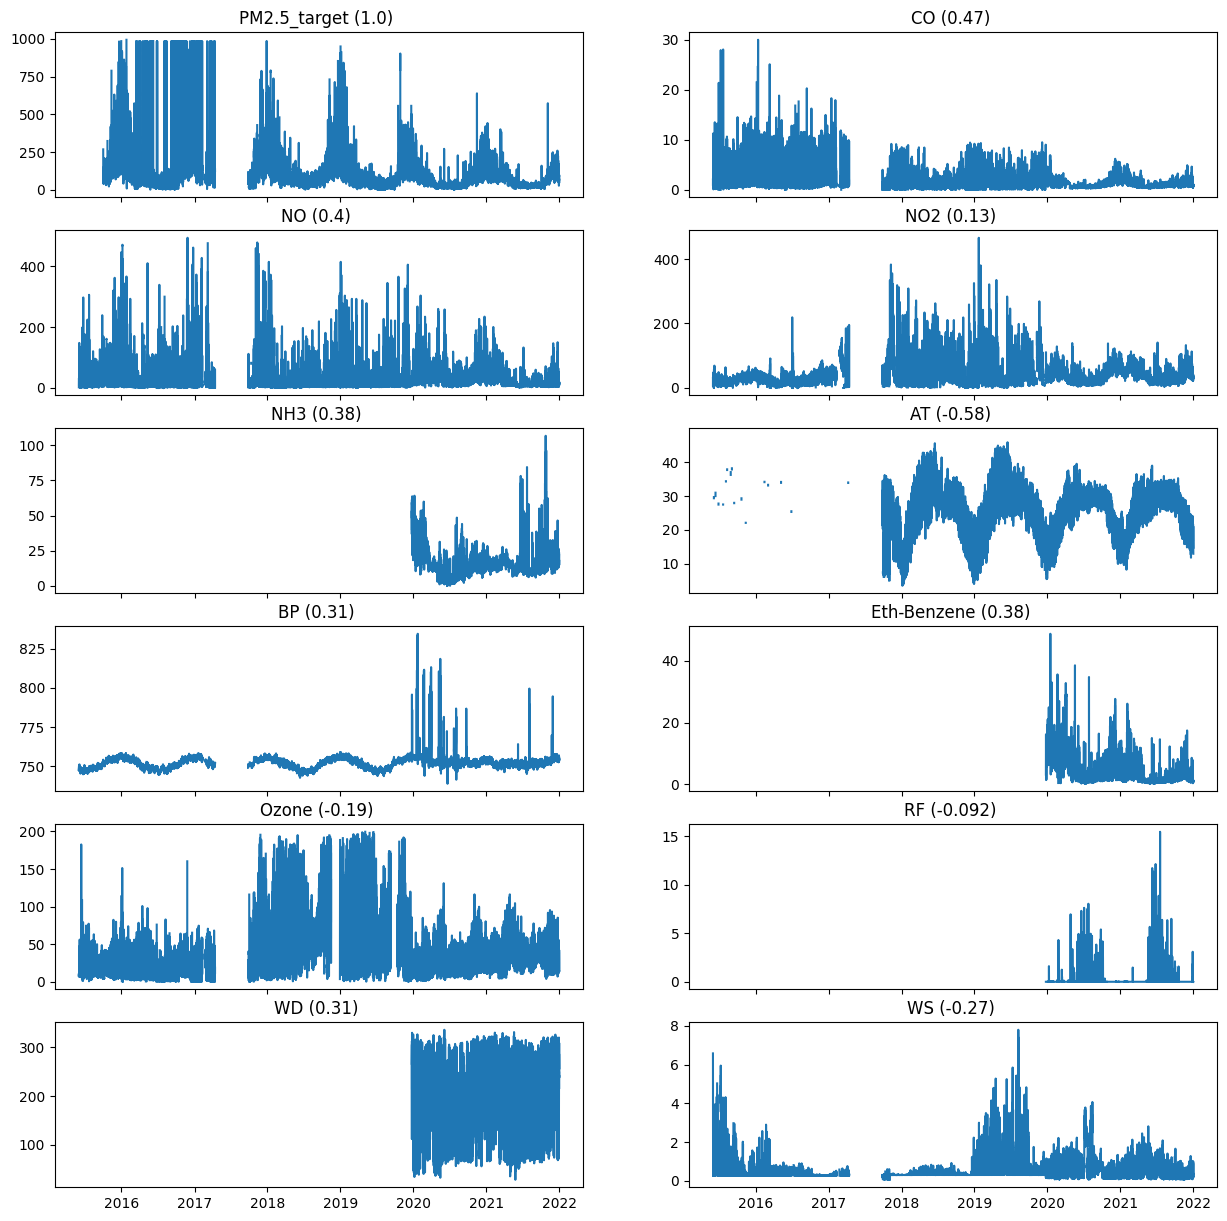

In [18]:
nrows, ncols = len(df_city.drop(['PM2.5'], axis=1).columns) // 2 , 2
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 15), sharex=True)

for i,column in enumerate(df_city.drop(['PM2.5'], axis=1).columns):

    ax[i//2, i%2].plot(df_city.drop(['PM2.5'], axis=1)[column])
    ax[i//2, i%2].set_title(column + ' ({:.2}) '.format(pearson_corr[column]['PM2.5_target']))


# Dataset

In [19]:
df_city = df_city[['PM2.5_target', 'PM2.5', 'CO', 'NO', 'AT', 'Ozone', 'WS']]

In [20]:
# Select train data and validation data
train_start_date = '2018-01-01'
val_start_date = '2021-01-01'

idx = pd.IndexSlice
df_train =df_city.loc[idx[train_start_date:val_start_date,]]
df_val = df_city.loc[idx[val_start_date:,]]

for column in df_train.columns:

    df_train[column].replace({np.nan: np.mean(df_train[column])}, inplace=True)

for column in df_val.columns:

    df_val[column].replace({np.nan: np.mean(df_val[column])}, inplace=True)


<ipython-input-20-8a0f8b483f8e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.replace({np.nan: 0}, inplace=True)
<ipython-input-20-8a0f8b483f8e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.replace({np.nan: 0}, inplace=True)


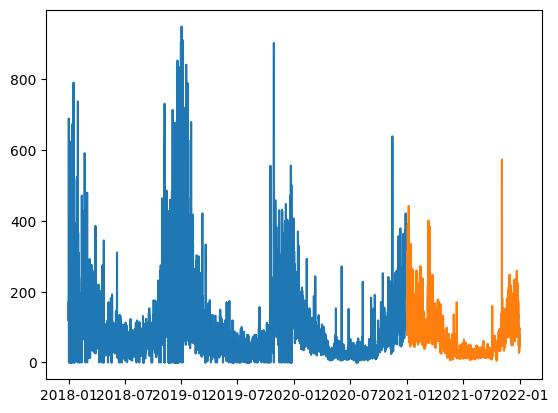

In [21]:
plt.figure()
plt.plot(df_train['PM2.5_target'])
plt.plot(df_val['PM2.5_target'])

In [22]:
class CityDataset(Dataset):
    # We could also define our constructor to take a pandas dataframe and extract the
    # features / targets directly. Notice that we must also specify a sequence length
    def __init__(self, X, y, seq_len):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        self.seq_len = seq_len

    def __len__(self):
        return self.y.shape[0] - self.seq_len

    def __getitem__(self, idx):
        return self.X[idx:idx+self.seq_len], self.y[idx:idx+self.seq_len]

In [23]:
# Create the dataset based on our training data
dataset = CityDataset(
    X=df_train.drop("PM2.5_target", axis=1).values,
    y=df_train[["PM2.5_target"]].values,
    seq_len=24
)

# Create a dataloader, loading 32 batches of sequences at a time
dataloader = DataLoader(dataset, batch_size=32)

In [24]:
# Look at how one single batch looks like...
for x, y in dataloader:
    print("First Batch:")
    print(f" X shape: {x.shape}")
    print(f" Y shape: {y.shape}")
    break

First Batch:
 X shape: torch.Size([32, 24, 6])
 Y shape: torch.Size([32, 24, 1])


# Gated Recurrent Unit (GRU)

In [25]:
# Create a recurrent network
class MyRNN(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden):
        super().__init__()
        # Use a Gated Recurrent Unit (beware of the batch_first parameter!)
        self.rnn = nn.GRU(n_inputs, n_hidden, batch_first=True)
        self.linear = nn.Linear(n_hidden, n_outputs)

    # Define the forward pass to remove the hidden state from the output
    def forward(self, x):
        # Apply the RNN
        x, _ = self.rnn(x) # (output, hidden state), discard the hidden state
        # Apply the linear layer
        x = self.linear(x)
        return x

In [26]:
# Use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate an RNN with num_features inputs, 1 output and 32 hidden nodes
num_features = len(df_train.drop("PM2.5_target", axis=1).columns)
gru = MyRNN(num_features, 1, 32).to(device)

# Use mean-square error as a loss
loss_fn = nn.MSELoss()

In [27]:
# Notice that the typical training structure doesn't change
n_epochs = 50
losses = np.zeros(n_epochs)

# Instantiate Adam optimizer with learning rate 0.0001
opt = optim.Adam(gru.parameters(), lr=1e-3)

gru.train()
for epoch in tqdm(range(n_epochs), desc="Training Network...", unit="epoch"):
    # Within each epoch, we iterate over the batches
    for X, y in dataloader:
        # Pass the batch to the GPU
        X = X.to(device)
        y = y.to(device)

        # Reset the gradients
        opt.zero_grad()

        # Compute the forward pass
        y_pred = gru(X)

        # Compute the loss
        loss = loss_fn(y, y_pred)

        # Compute the gradients
        loss.backward()

        # Update the parameters
        opt.step()

        # Store the epoch average losses to plot later on
        losses[epoch] += loss.detach().cpu().numpy() / y.shape[0]

Training Network...: 100%|██████████| 50/50 [07:58<00:00,  9.56s/epoch]


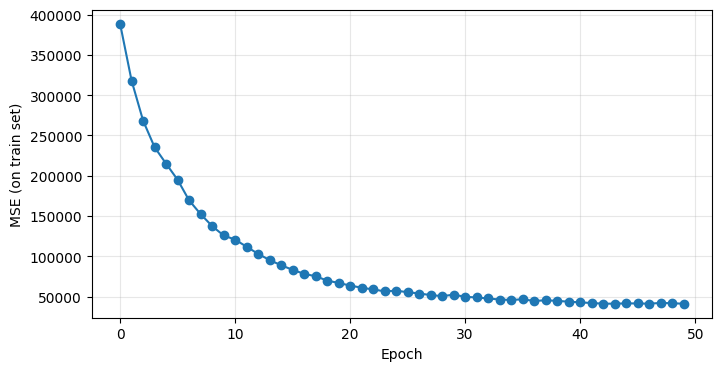

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(losses, "-o")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (on train set)")
ax.grid(alpha=.3)

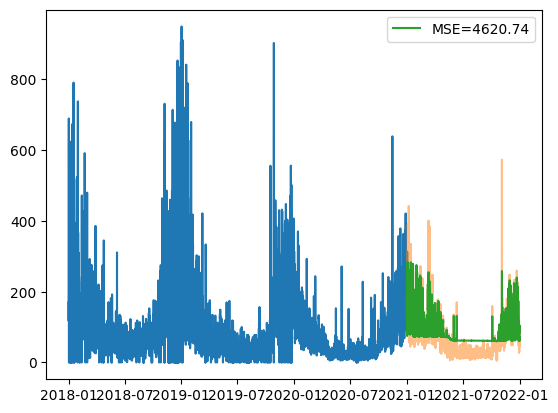

In [29]:
# Make predictions
X = df_val.drop("PM2.5_target", axis=1).values
y_true = df_val[["PM2.5_target"]].values

X = torch.Tensor(X).reshape(1, *X.shape).to(device)

gru.eval()
y_pred = gru(X).detach().cpu().numpy().reshape(-1)
gru.train()

mse = np.mean((y_pred - y_true)**2)

plt.figure()
plt.plot(df_train['PM2.5_target'])
x = df_val.index.get_level_values('date').values
plt.plot(x, y_true, alpha=0.5)
plt.plot(x, y_pred, label='MSE={:.6}'.format(mse))
plt.legend()

# Make predictions

In [30]:
features_to_remove = list(set(df_test.columns) - set(df_train.columns))
df_test = df_test.xs(city, level='city').drop(features_to_remove, axis=1)
df_test.replace({np.nan: 0}, inplace=True)

In [31]:
predictions = [df_val.loc['2021-12-31 23:00:00']['PM2.5_target'], ]

X = df_test.values

gru.eval()

for i in range(1, len(X)):

    x = torch.Tensor([predictions[-1], *X[i]]).to(device).reshape(1, 1, -1)
    prediction = gru(x).detach().cpu().item()

    predictions.append(prediction)

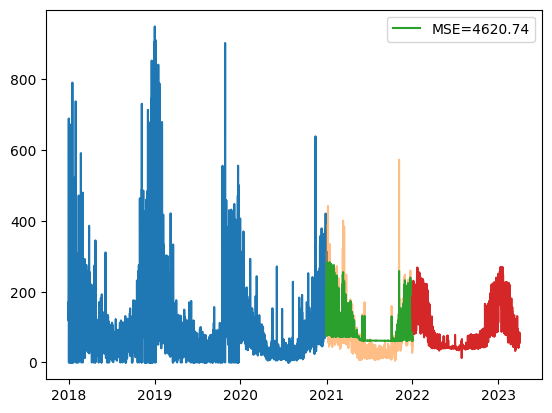

In [32]:
plt.figure()
plt.plot(df_train['PM2.5_target'])
x = df_val.index.get_level_values('date').values
plt.plot(x, y_true, alpha=0.5)
plt.plot(x, y_pred, label='MSE={:.6}'.format(mse))
plt.plot(df_test.index.get_level_values('date'), predictions)
plt.legend()